# Engenharia do Conhecimento 2023/2024

## Lab class TP06

# The K-nearest Neighbour classifier and preprocessing data

*A Machine Learning Tutorial by Andre Falcao (DI/FCUL 2020-2022)*
*revised by Catia Pesquita (DI/FCUL 2022-2023) and Sofia Teixeira (DI/FCUL 2022-2023)*
### Summary


1. K-Nearest Neighbours
    1. K nearest nighbours for regression
    2. K-Nearent neighbours for classification
    4. Improving the model with Kernels
    
3. Scaling Data

2. Handling missing values in data


## 1. Introduction to K-Nearest Neighbours (KNN)

The idea of K nearest neighbours is very simple. It is based on the concept that similar behaviours should appear on items that are near each other. There are thus two issues to solve in KNN

1. How many neighbours?
2. What is "near"?

For the current example we will only use the standard Euclidean distance, although it can be changed at will

### 1.1. A KNN classifier from scratch

A KNN classifier can be simply defined with a class with 3 methods

* A constructor that receives the training data and the number of K neighbours
* A decision function that for the data from the set of neighbours is able to make a decision. In this case we are going to check the dominant class
* A prediction function that will receive a data set of new data and for each will compute the distance between each new instance and all the others in the training set and will return the results from the decision function

We are going to use scipy  function `distance_matrix` that compares one data set `te` as a matrix $N_{tr}.M$ with another data set `tr`, $N_{te}.M$ to produce a new matrix $D=N_{tr}.N_{te}$ with the distances from each element `te` to each element of `tr`. This function is able to use all distances produced by the Minkwosky distance, with the default being the Euclidean

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from scipy.spatial import distance_matrix

class knn_classifier:
    def __init__(self, X_train, y_train, K=1):
        self.data=X_train
        self.labels=y_train
        self.K=K

    def decide(self, results):
        #majority decision
        vals, cnts=np.unique(results, return_counts=True)
        res=list(zip(cnts, vals))
        res=sorted(res, reverse=True)
        return res[0][1]
        
    def predict(self, instances):
        N,M=instances.shape
        dst=distance_matrix(self.data, instances)
        preds=np.zeros(N, dtype=int)
        for i in range(N):
            ords=np.argsort(dst[:,i])
            res=self.labels[ords[:self.K]]
            preds[i]=self.decide(res)
        return preds

### Exercise 1

Run the familiar Iris dataset to identify the best possible number of Neighbours

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report


X,y=load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


########### Your Solution #############
best_f1_score = 0
best_K = 0

for K in range(1, 21):  
    knn = knn_classifier(X_train, y_train, K=K)
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    if f1 > best_f1_score:
        best_f1_score = f1
        best_K = K

print("Best K:", best_K)
print("Best F1-score:", best_f1_score)





Best K: 16
Best F1-score: 1.0


### 1.3. Playing with Scikit learn

Scikit learn has two powerful KNN implementations for classification and regression, respectively.

These implementations allow not only to select the numberr of Neighbours, but allow for different weighting, based on distance, bith for regression and classification. They also allow for using distance modification functions for more complex kernels.

As KNN can be a very CPU intensive algorithm, scikit allows for using specific algorithms for searching for similar items  (ball tree and KDTree) as well as using several threads for parallel searching of neighbours

### 1.4. Distance weighting

By default KNN regression or classification consideres each neighbour found as contributing equally to the final result, disregarding any effect of the distance. Yet it may convenient to weight each distance to each of the neighbours found according to the inverse of the distance

$w_i= \dfrac{1}{d_i}$

Larger distances will have a smaller impact on the inferred value, then closer instances. 

To visualise the effect of the weight function in regression we are going to use a very simple data problem with 1 feature. The testing set contains 100 X values ranging from 0.0 to 10.0  

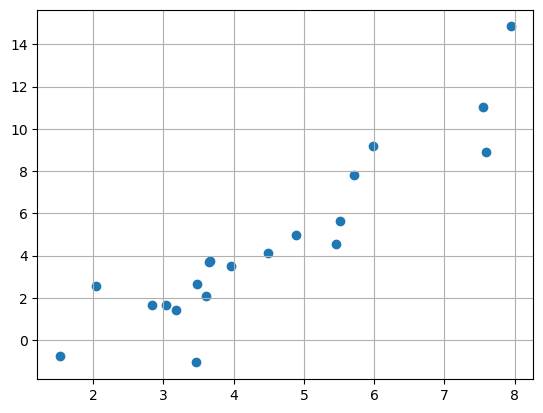

In [4]:
import pickle
X_train, y_train, X_test, y_test = pickle.load(open("data.pickle", "rb"))
plt.scatter(X_train[:,0], y_train)
plt.grid()
plt.show()

It is possible to see that the KNN regressor without any weights works in steps, keeping the same value. As long as the neighbours do not change, the prediction will also not change

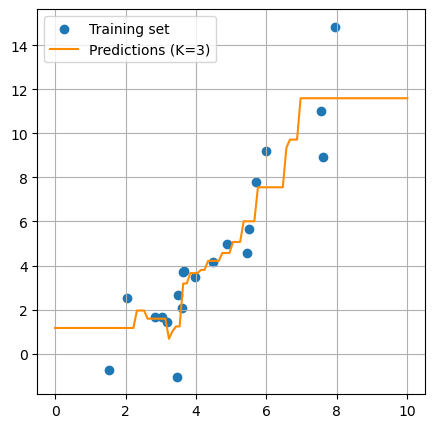

In [5]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)
preds = knn.predict(X_test)
plt.figure(figsize=(5,5))
plt.scatter(X_train,y_train, label="Training set")
plt.plot(X_test, preds, color="darkorange", label="Predictions (K=3)")
plt.legend()
plt.grid()
plt.show()

With inverse distance weighting, the impact of each nearby point can be seen a a spike.

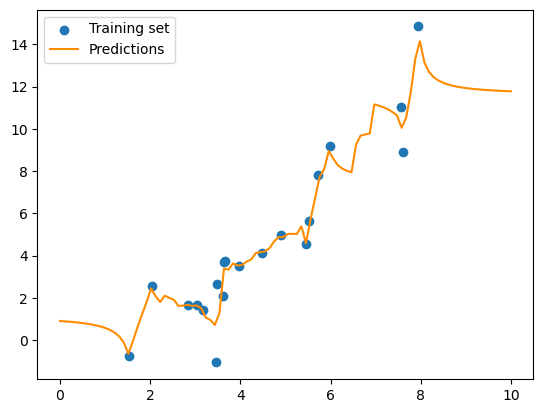

In [6]:
knn = KNeighborsRegressor(n_neighbors=3, weights="distance")
knn.fit(X_train, y_train)
preds = knn.predict(X_test)
plt.scatter(X_train,y_train, label="Training set")
plt.plot(X_test, preds, color="darkorange", label="Predictions")
plt.legend()
plt.show()

### 1.5 Kernel Weighting

Inverse distance Weighting can be replaced by a sigmoid function, or any other function, for that matter. Replacing the distance with a sigmoid: 

$w_i= e^{-\frac{d_i^2}{kw}}$

This function will require one further parameter, `kw`, a kernel weight function that can be fit for whatever purpose. On any case, this softer weighting will create a better interpolation. 

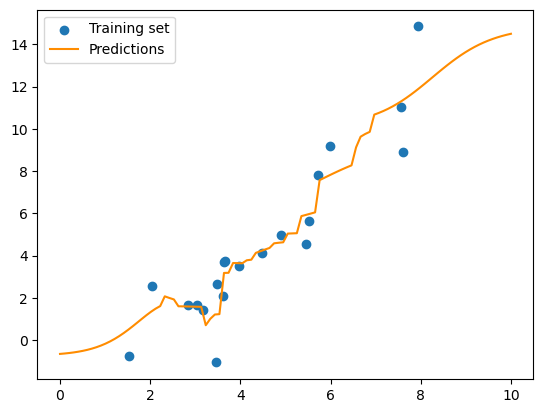

In [7]:
def gaussian(dsts):
    kernel_width = .5
    weights = np.exp(-(dsts**2)/kernel_width)
    return weights

knn = KNeighborsRegressor(n_neighbors=3, weights=gaussian)
knn.fit(X_train, y_train)
preds = knn.predict(X_test)
plt.scatter(X_train,y_train, label="Training set")
plt.plot(X_test, preds, color="darkorange", label="Predictions")
plt.legend()
plt.show()

Let's see the impact of K vs weighting functions in a single plot combination

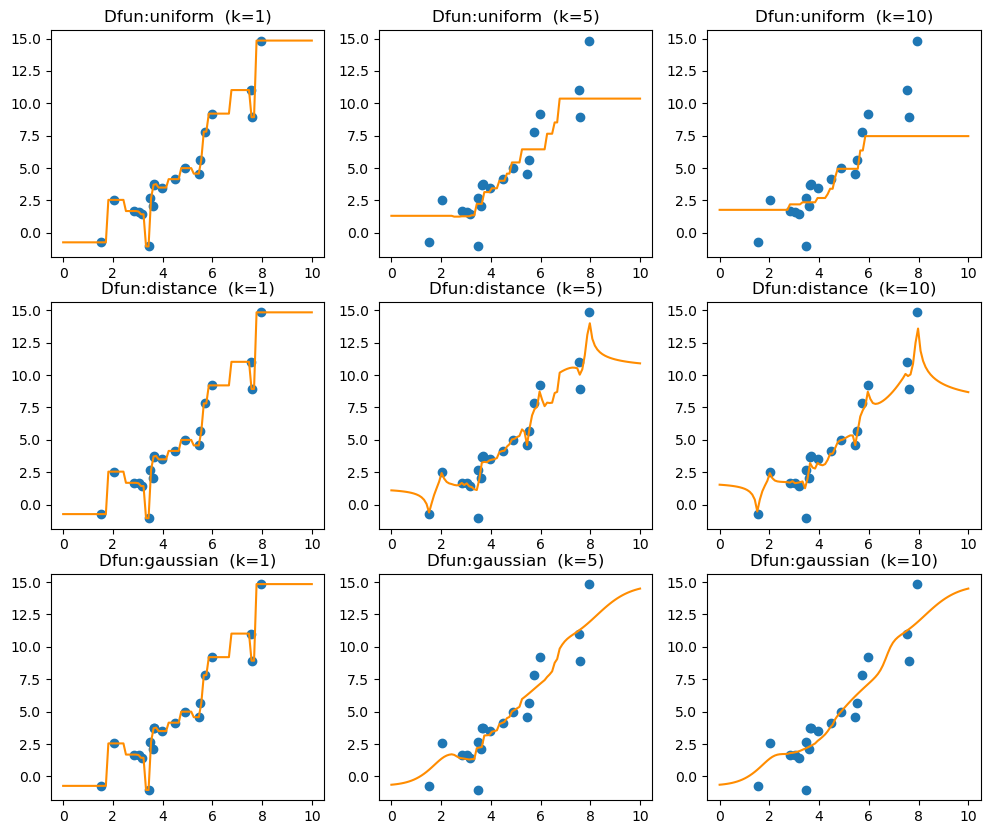

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(12,10))
for i, wfun in enumerate( ["uniform", "distance", gaussian]):
    for j, k in enumerate([1,5,10]):
        knn = KNeighborsRegressor(n_neighbors=k, weights=wfun) #weights="distance")
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        s= wfun if wfun!=gaussian else "gaussian"
        axs[i,j].set_title("Dfun:%s  (k=%d)" %(s, k))
        axs[i,j].scatter(X_train,y_train)
        axs[i,j].plot(X_test, preds, color="darkorange")

#### Exercise 2
1. Comment and discuss the results above

In [9]:
#Uniform Weighting: This assigns equal weight to all neighbors. The predictions show a step-like behavior.

#Inverse Distance Weighting: Closer neighbors have more influence on the predictions. 
#This creates spikes in the predictions, especially when there are outliers or when the data is sparse.

#Gaussian Kernel Weighting: This provides a smoother interpolation compared to inverse distance weighting. 
#The predictions exhibit a more continuous behavior, resulting in a smoother curve.

#We can aslo detect that with more neighbors the value of the prediction are not as correct, and inverse distance 
#seems to show the ebst aproximation on all neighbors

### 1.6. Fitting KNN Regression to an actual data set

Let's try the KNN Regression in a data set, using K=3, doing a full regression analysis.

We will use the diabetes dataset for experimenting **Please note that we will use only 3 columns of X**

In [10]:
from sklearn.datasets import load_diabetes
X,y=load_diabetes(return_X_y=True)
X=X[:,7:10] #<-----Just the 3 last columns 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train.shape

(353, 3)

This will fit a KNN with K=3 and no distance weighting

In [11]:
from sklearn.metrics import r2_score, root_mean_squared_error, max_error, mean_absolute_error
from scipy.stats import pearsonr


def present_reg_statistics(truth, preds):
    print("The R2 is: ", r2_score(truth, preds))
    print("The rmse is: ", root_mean_squared_error(truth, preds))
    corr, pval = pearsonr(truth, preds)
    print("The Correlation Score is is: %6.4f (p-value=%e)\n"%(corr,pval))
    print("The Maximum Error is is: ", max_error(truth, preds))
    print("The Mean Absolute Error is: ", mean_absolute_error(truth, preds))
    plt.figure(figsize=(5,5))
    plt.scatter(preds, y_test)
    plt.plot((50, 350), (50, 350), c="r")
    plt.ylabel("predictions")
    plt.xlabel("real values")
    plt.grid()
    plt.show()

knn = KNeighborsRegressor(n_neighbors=3 )
knn.fit(X_train, y_train)
preds = knn.predict(X_test)

preds=knn.predict(X_test)

present_reg_statistics(y_test, preds)

ImportError: cannot import name 'root_mean_squared_error' from 'sklearn.metrics' (C:\Users\panke\anaconda3\Lib\site-packages\sklearn\metrics\__init__.py)

The R2 is:  0.3289079100851978
The rmse is:  4227.9925093632955
The Correlation Score is is: 0.5974 (p-value=6.422343e-10)

The Maximum Error is is:  161.33333333333334
The Mean Absolute Error is:  53.7003745318352


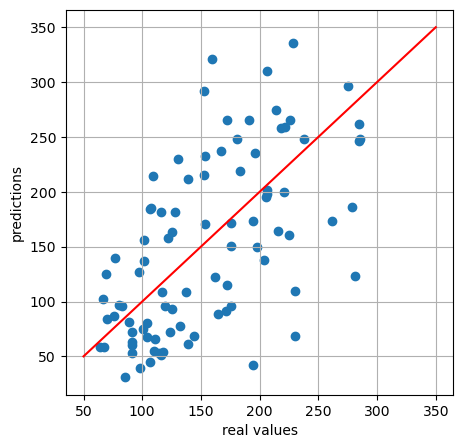

In [12]:
from sklearn.metrics import r2_score, mean_squared_error, max_error, mean_absolute_error
from scipy.stats import pearsonr


def present_reg_statistics(truth, preds):
    print("The R2 is: ", r2_score(truth, preds))
    print("The rmse is: ", mean_squared_error(truth, preds))
    corr, pval = pearsonr(truth, preds)
    print("The Correlation Score is is: %6.4f (p-value=%e)\n"%(corr,pval))
    print("The Maximum Error is is: ", max_error(truth, preds))
    print("The Mean Absolute Error is: ", mean_absolute_error(truth, preds))
    plt.figure(figsize=(5,5))
    plt.scatter(preds, y_test)
    plt.plot((50, 350), (50, 350), c="r")
    plt.ylabel("predictions")
    plt.xlabel("real values")
    plt.grid()
    plt.show()

knn = KNeighborsRegressor(n_neighbors=3 )
knn.fit(X_train, y_train)
preds = knn.predict(X_test)

preds=knn.predict(X_test)

present_reg_statistics(y_test, preds)

Now let's change K to investigate its impact on the RMSE

In [13]:
ks=np.arange(1,50,2) 
rmses=np.zeros(ks.shape[0])
for i,k in enumerate(ks):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    rmses[i]=root_mean_squared_error(y_test, preds)

plt.plot(ks, rmses)
plt.ylabel("RMSE")
plt.xlabel("K")
plt.grid()
plt.show()

NameError: name 'root_mean_squared_error' is not defined

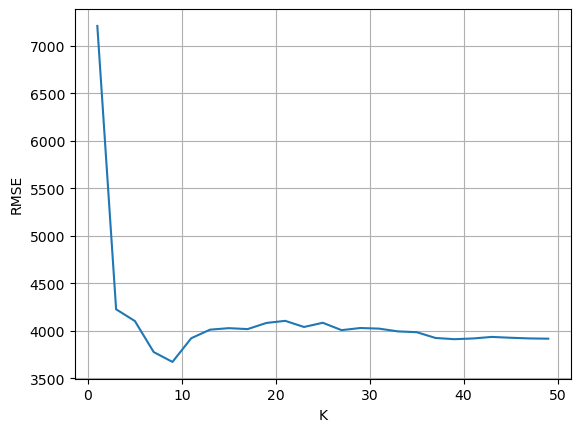

In [14]:
ks=np.arange(1,50,2) 
rmses=np.zeros(ks.shape[0])
for i,k in enumerate(ks):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    rmses[i]=mean_squared_error(y_test, preds)

plt.plot(ks, rmses)
plt.ylabel("RMSE")
plt.xlabel("K")
plt.grid()
plt.show()

#### Exercise 3

1. With the results above what do you think is the best K?
2. How confident are you in this result? 
3. With this "optimal K", compute all the regression and compare them to the original estimate

The R2 is:  0.4168596295864898
The rmse is:  3673.881953114163
The Correlation Score is is: 0.6490 (p-value=6.039765e-12)

The Maximum Error is is:  177.33333333333334
The Mean Absolute Error is:  49.73408239700374


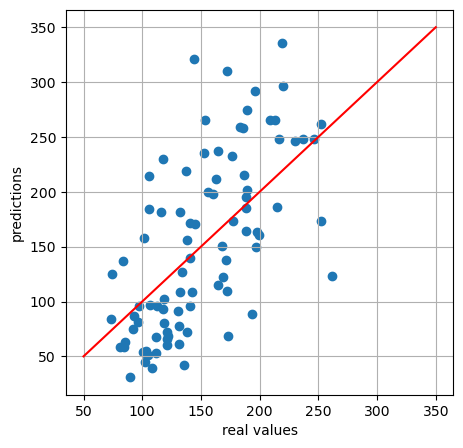

In [15]:
#(RMSE) is a measure of the differences between values predicted by a model and the values observed. 
#It gives you a sense of how far off your predictions are from the actual values.

#The RMSE values can range from 0 to positive infinity. 
#A lower RMSE indicates a better fit of the model to the data.
#the best k seems to be 9 or 8 since it has the lowest rmse

#I would need to check higher values than 50 sicne the line is going down and the result with k=9 is a sudden dip i nthe line 
#DUVIDA --------------------------------------------------------------------
#Chat Gpt disse , if the landscape is erratic, with fluctuating valleys, it implies uncertainty in selecting the best K. 
#Confidence also stems from validation techniques like cross-validation, which corroborates the stability of the chosen K 
#across different data splits.

from sklearn.datasets import load_diabetes
X,y=load_diabetes(return_X_y=True)
X=X[:,7:10] #<-----Just the 3 last columns 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train.shape
from sklearn.metrics import r2_score, mean_squared_error, max_error, mean_absolute_error
from scipy.stats import pearsonr


def present_reg_statistics(truth, preds):
    print("The R2 is: ", r2_score(truth, preds))
    print("The rmse is: ", mean_squared_error(truth, preds))
    corr, pval = pearsonr(truth, preds)
    print("The Correlation Score is is: %6.4f (p-value=%e)\n"%(corr,pval))
    print("The Maximum Error is is: ", max_error(truth, preds))
    print("The Mean Absolute Error is: ", mean_absolute_error(truth, preds))
    plt.figure(figsize=(5,5))
    plt.scatter(preds, y_test)
    plt.plot((50, 350), (50, 350), c="r")
    plt.ylabel("predictions")
    plt.xlabel("real values")
    plt.grid()
    plt.show()

knn = KNeighborsRegressor(n_neighbors=9 )
knn.fit(X_train, y_train)
preds = knn.predict(X_test)

preds=knn.predict(X_test)

present_reg_statistics(y_test, preds)

#------------------------original
#The R2 is:  0.3289079100851978
#The rmse is:  4227.9925093632955
#The Correlation Score is is: 0.5974 (p-value=6.422343e-10)

#The Maximum Error is is:  161.33333333333334
#The Mean Absolute Error is:  53.7003745318352   
#The R2 value increased from 0.3289 to 0.4169, indicating an improvement in the explained variance of the model.
 #   The RMSE decreased from 4227.9925 to 3673.8820, showing a reduction in the average error of the model's predictions.
  #  The correlation score increased from 0.5974 to 0.6490, indicating a stronger linear relationship between the predicted and true values.
  #  The maximum error increased slightly from 161.3333 to 177.3333.
  #  The mean absolute error decreased from 53.7004 to 49.7341, indicating a reduction in the average absolute difference between the predicted and true values.

#Overall, the regression with the optimal K value for KNN showed improvements 
##


What is the difference if we use distance weighting for different values of K

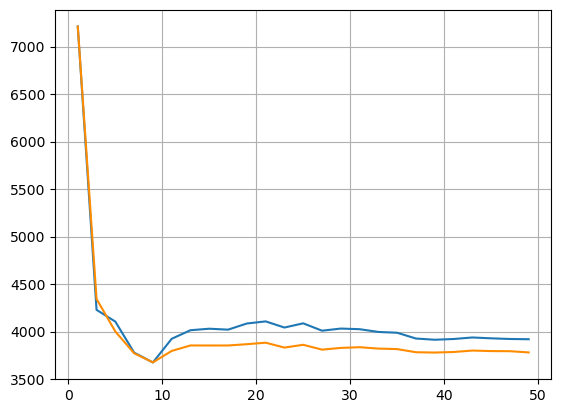

In [16]:
ks=np.arange(1,50,2) 
rmses_w=np.zeros(ks.shape[0])
for i,k in enumerate(ks):
    knn = KNeighborsRegressor(n_neighbors=k, weights="distance")
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    rmses_w[i]=mean_squared_error(y_test, preds)

plt.plot(ks, rmses)
plt.plot(ks, rmses_w, color="darkorange")
plt.grid()
plt.show()

#### Exercise 4

1. Discuss the results above
2. Run the code above, but this time run it with all the columns from X, by commenting out the line with 
`X=X[:,7:10]`
    1. Discuss your findings


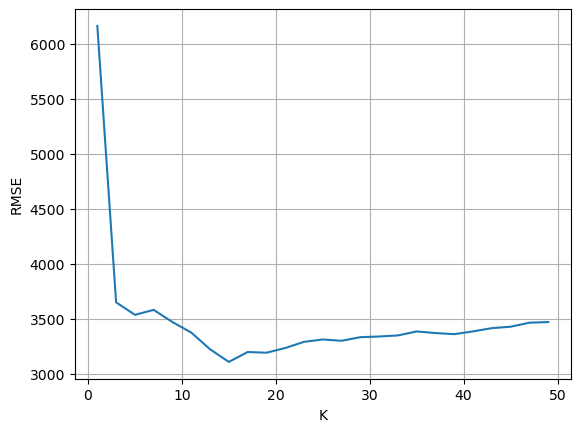

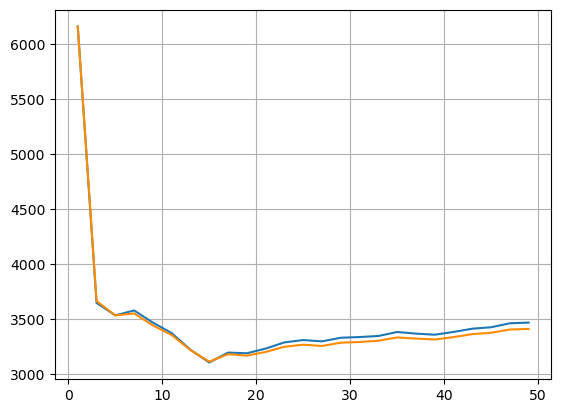

In [17]:
# Your Solution
# We can see that distance has lower rmse hence is better than no distance weighting


from sklearn.datasets import load_diabetes
X,y=load_diabetes(return_X_y=True)
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train.shape
from sklearn.metrics import r2_score, mean_squared_error, max_error, mean_absolute_error
from scipy.stats import pearsonr


ks=np.arange(1,50,2) 
rmses=np.zeros(ks.shape[0])
for i,k in enumerate(ks):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    rmses[i]=mean_squared_error(y_test, preds)

plt.plot(ks, rmses)
plt.ylabel("RMSE")
plt.xlabel("K")
plt.grid()
plt.show()


ks=np.arange(1,50,2) 
rmses_w=np.zeros(ks.shape[0])
for i,k in enumerate(ks):
    knn = KNeighborsRegressor(n_neighbors=k, weights="distance")
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    rmses_w[i]=mean_squared_error(y_test, preds)

plt.plot(ks, rmses)
plt.plot(ks, rmses_w, color="darkorange")
plt.grid()
plt.show()

#we can now see the best k is abut 15 

## 2. Data Scaling

Data scaling is a procedure that is absolutely required for KNN modeling, as the distances are influenced directly by the scales of the atributes. Some of the most common scalers for Machine Learning are

* [MinMax Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) - scales each feature so that each feature will totally fit with a specifed interval (generally [0, 1])
* [Standard Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) This one transforms each column of the data set into a new feature with Mean = 0 and Variance =1
* [Power Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.PowerTransformer) - applies a power transformation to each value, so that the resulting feature has the best possible approach to a normal distribution 
* [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html#sklearn.preprocessing.Normalizer) - Does not work on columns, but on rows, certifing that the norm of each intance is a unit vector (We won't be using this one in this TP)


To test these transformations, we will use the [Algeria Forest Fire dataset](https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++#), but only 7 columns. Some of the values are missing, but most scalers will not be affected by this (with the exception of the Normalizer, that obviously cannot be processed without first imputing the missing elements

In [18]:
alg=pd.read_csv("alg-ff1.txt", sep="\t")
X=alg.values[:,3:10]
y=alg["Classes"].values
all_columns=alg.columns
all_columns[np.array([0,1,2,10])]
alg.drop(all_columns[np.array([0,1,2,10])], axis=1, inplace=True)
pd.DataFrame(X, columns=alg.columns)

,Temperature,RH,Ws,Rain,DMC,DC,BUI
0,28.0,90.0,15.0,NaN,7.2,14.7,7.1
1,28.0,80.0,21.0,16.8,8.7,8.7,8.3
2,NaN,82.0,22.0,13.1,2.5,7.1,2.7
3,22.0,86.0,NaN,10.1,0.7,7.0,1.1
4,33.0,62.0,10.0,8.7,4.6,8.3,4.4
...,...,...,...,...,...,...,...
239,36.0,56.0,NaN,0.0,23.8,57.1,23.8
240,34.0,49.0,15.0,0.0,24.8,159.1,35.7
241,35.0,64.0,17.0,0.0,31.9,145.7,41.2
242,37.0,55.0,15.0,0.0,28.3,67.2,28.3


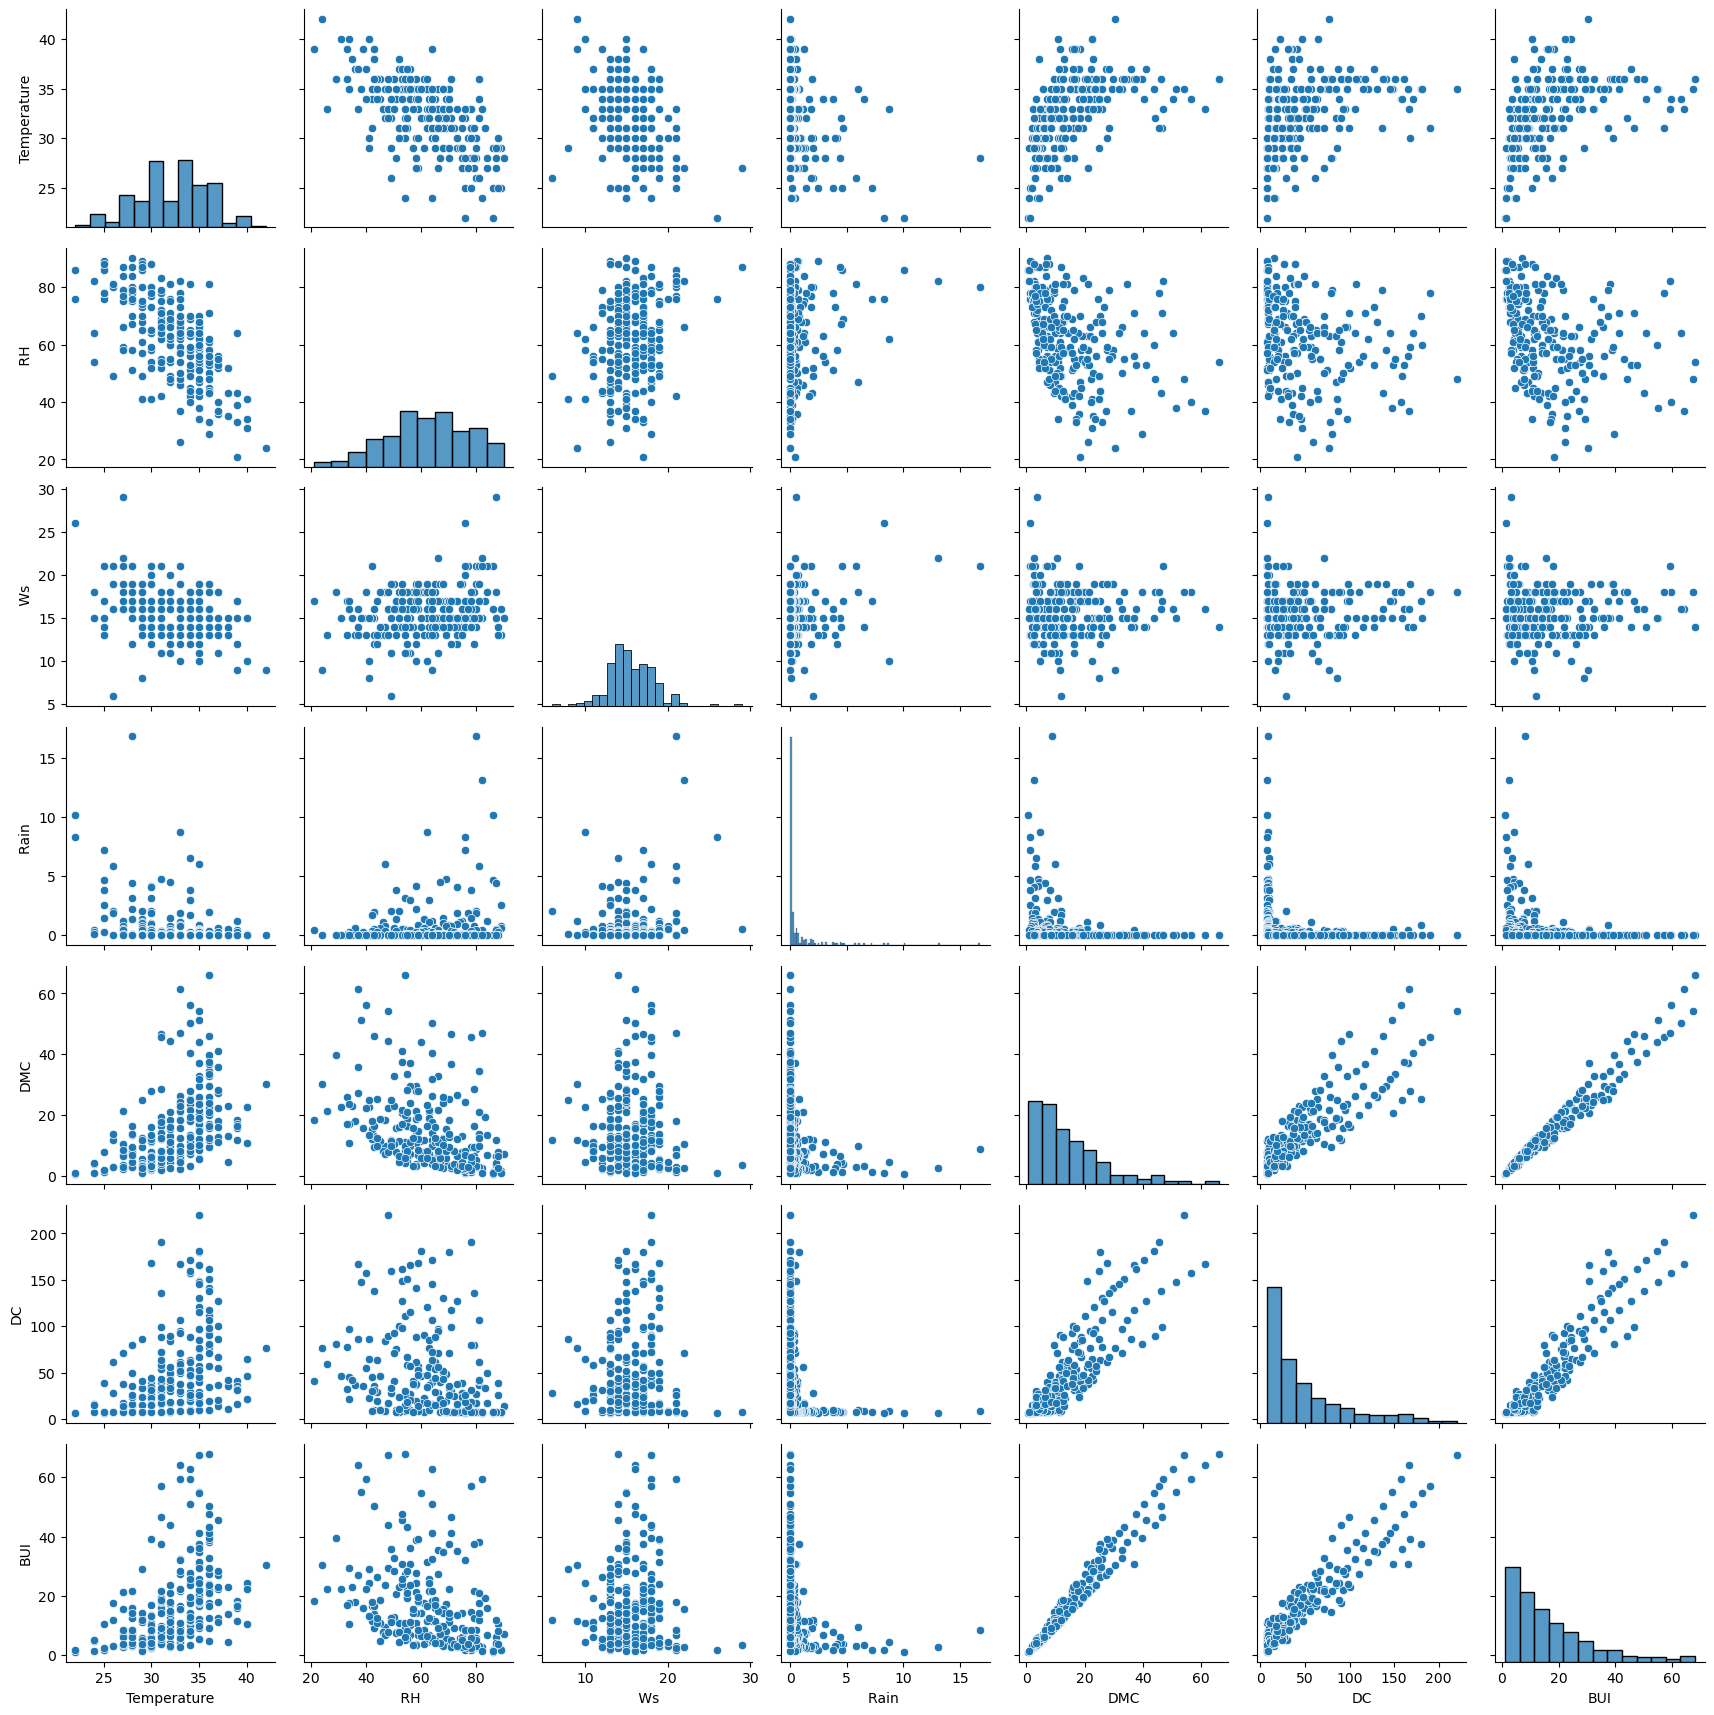

In [19]:
import seaborn as sns
g = sns.PairGrid(alg)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)


### 2.1. Running the MinMax Scaler

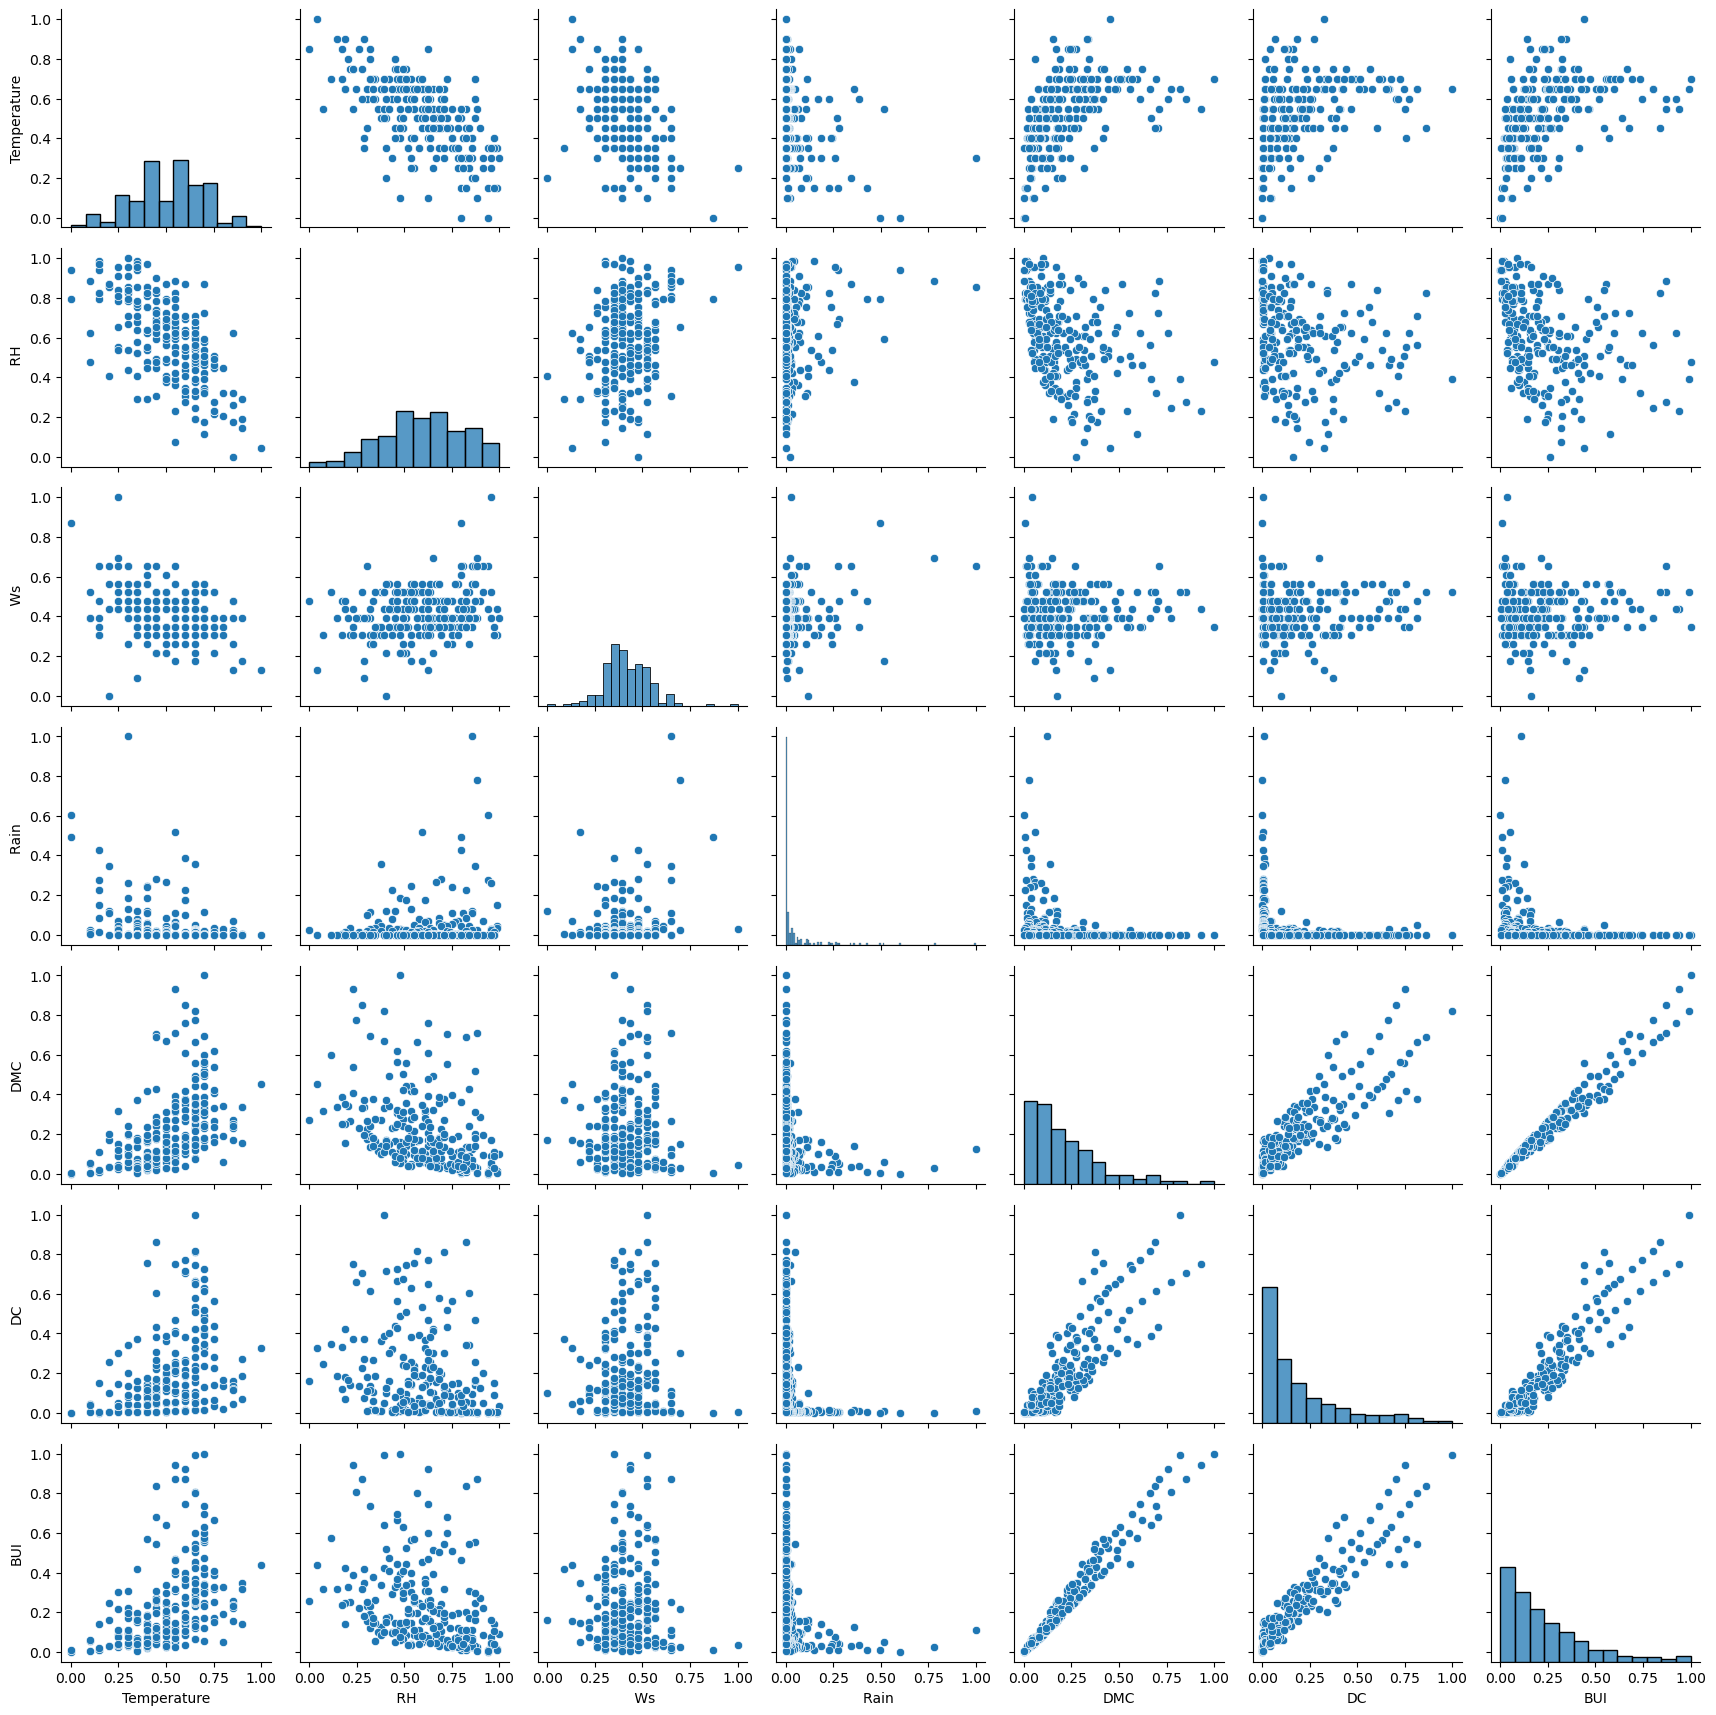

In [20]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, PowerTransformer
scaler = MinMaxScaler()
Xt=scaler.fit_transform(X)

g = sns.PairGrid(pd.DataFrame(Xt, columns=alg.columns))
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)



### 2.2. Running the Standard Scaler

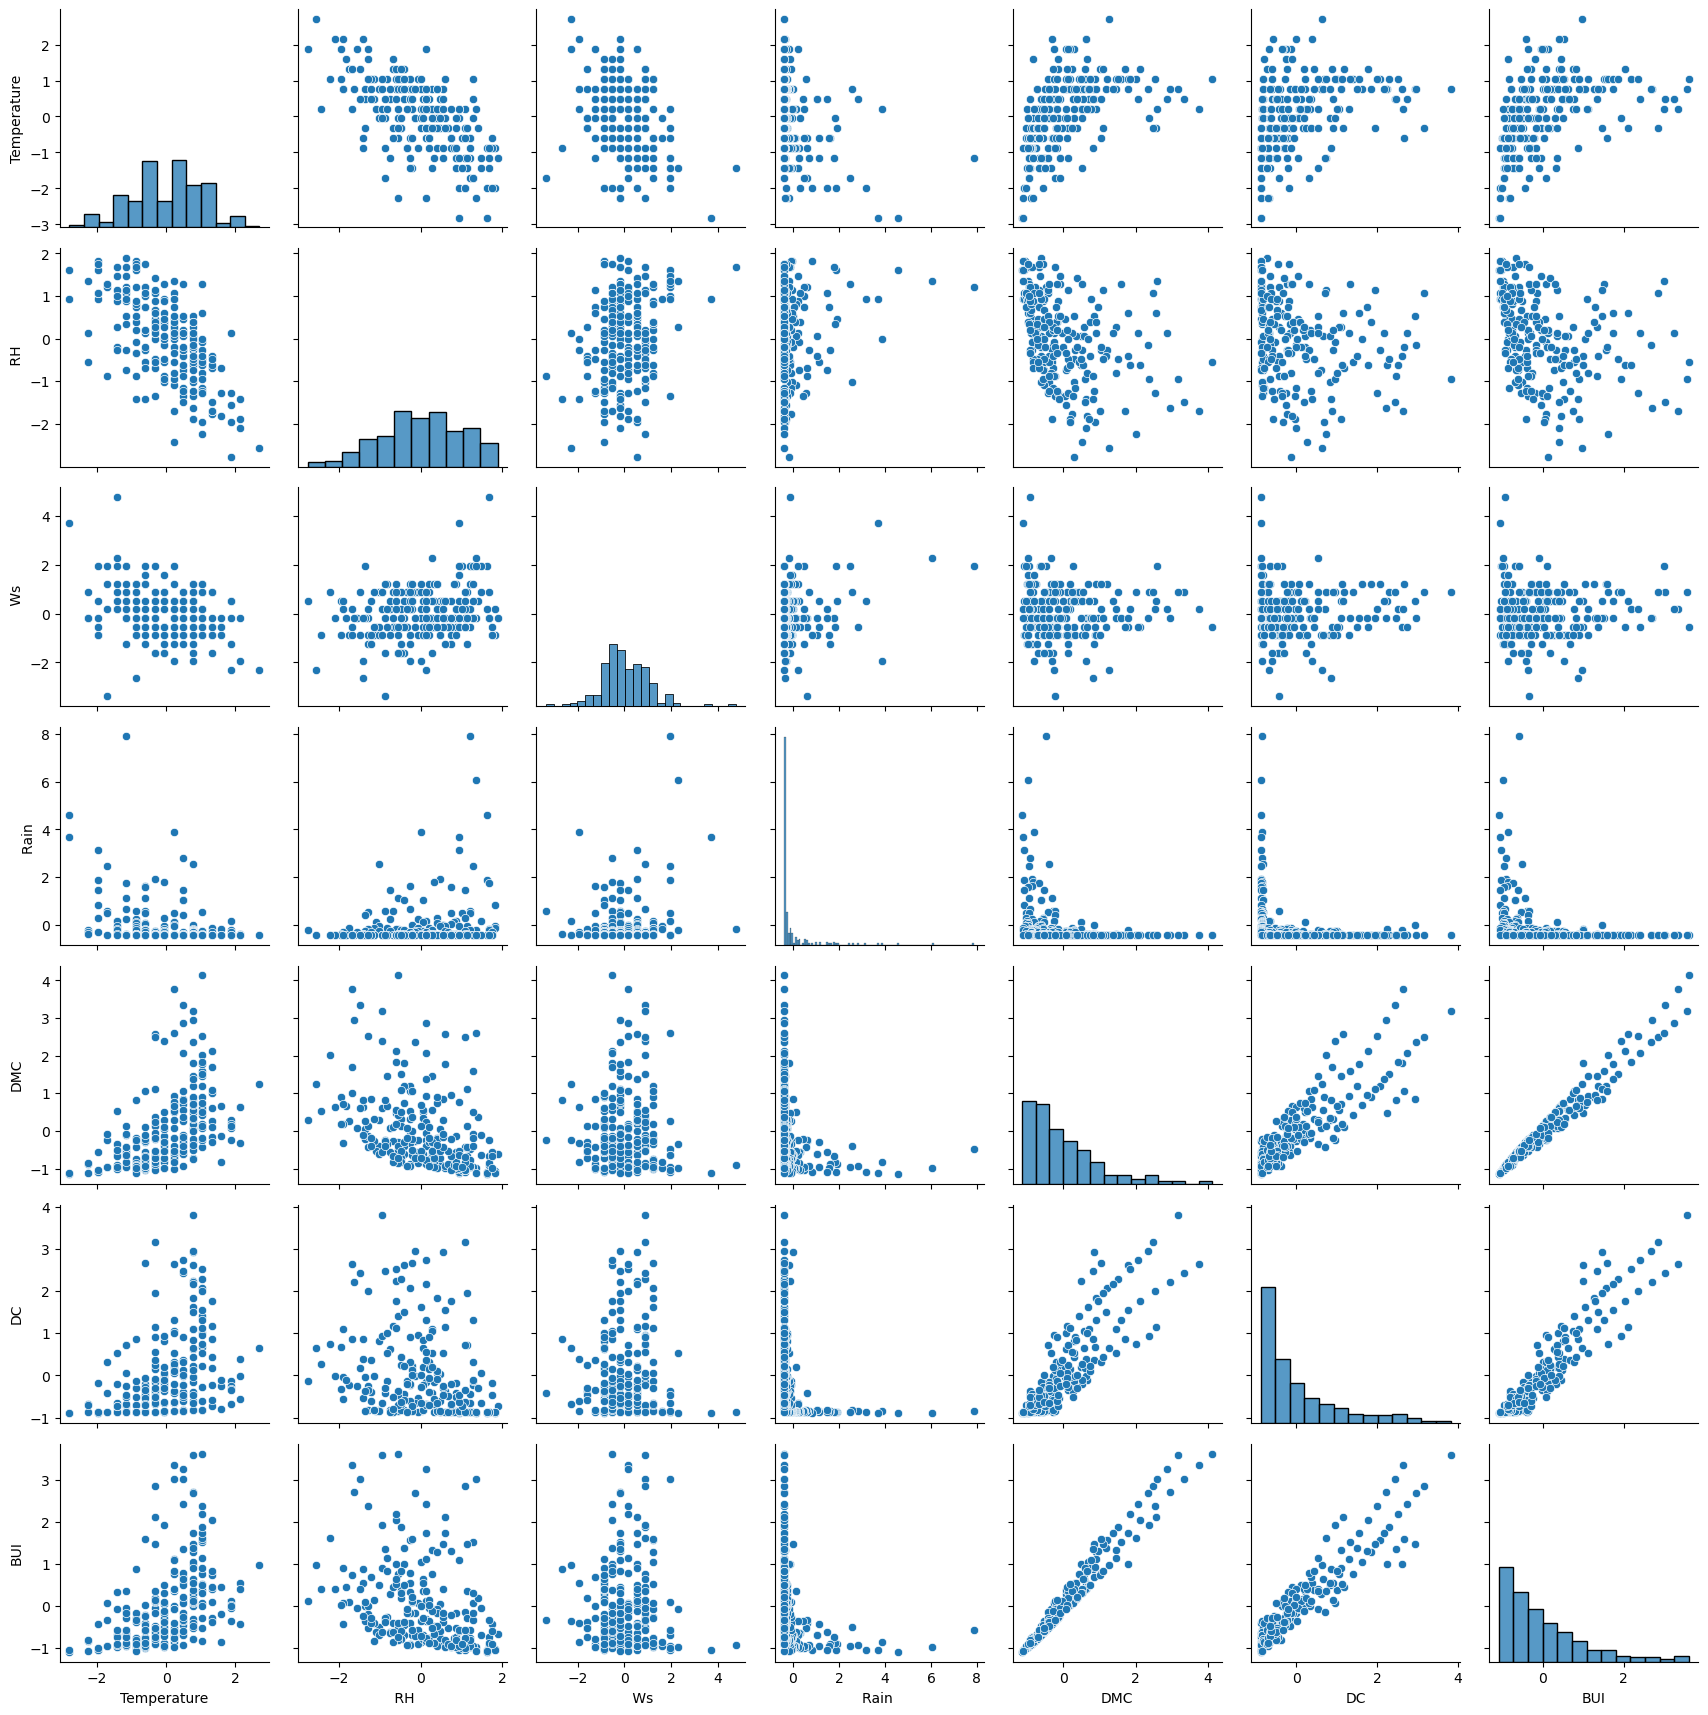

In [21]:
scaler = StandardScaler()
Xt=scaler.fit_transform(X)

g = sns.PairGrid(pd.DataFrame(Xt, columns=alg.columns))
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)


### 2.3. Running the Power Transformer

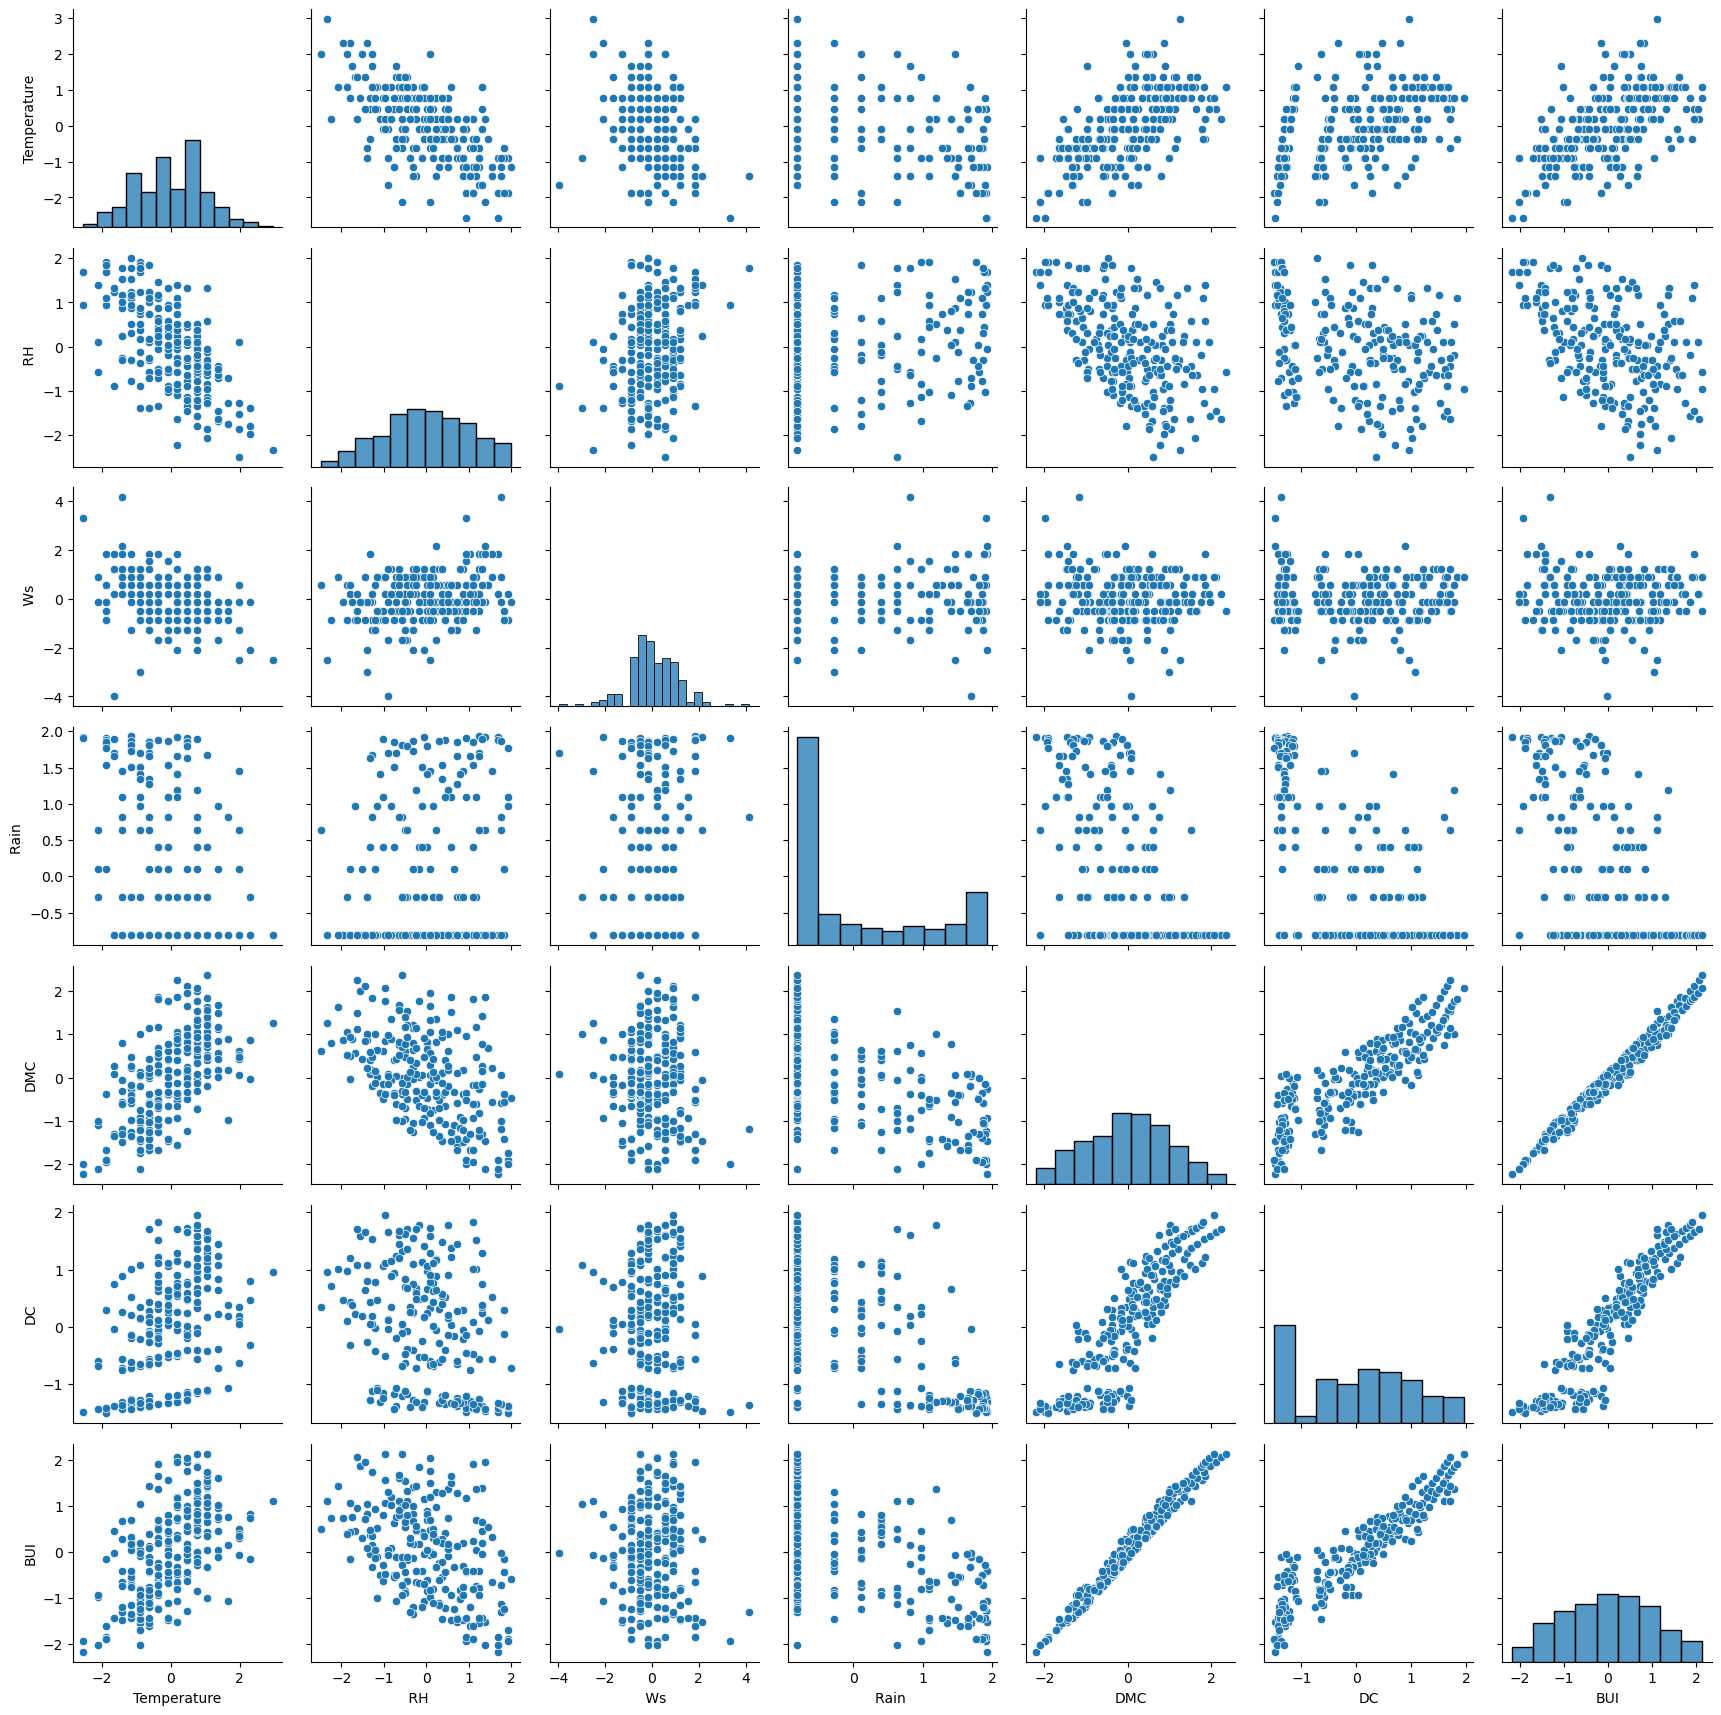

In [22]:
scaler = PowerTransformer()
Xt=scaler.fit_transform(X)

g = sns.PairGrid(pd.DataFrame(Xt, columns=alg.columns))
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)


## 3. Imputation of missing values

Two of the most common forms of imputation are Univariate imputation or Multivariate imputation. The former just puts in each missing value a constant, that is computed from the feature in question,typicallly  the mean, the median or the most common value (typically for categorical attributes)

Multivariate imputation in Scikit can be performed with KNN, where for each feature with missing values a model is generated using all the other available features

* [Univariate imputation](https://scikit-learn.org/stable/modules/impute.html#univariate-feature-imputation)
* [KNN Imputer](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation)

### 3.1. Univariate Imputation


In [23]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')
pd.DataFrame(imp.fit_transform(X))

,0,1,2,3,4,5,6
0,28.0,90.0,15.0,0.0,7.2,14.7,7.1
1,28.0,80.0,21.0,16.8,8.7,8.7,8.3
2,32.0,82.0,22.0,13.1,2.5,7.1,2.7
3,22.0,86.0,15.0,10.1,0.7,7.0,1.1
4,33.0,62.0,10.0,8.7,4.6,8.3,4.4
...,...,...,...,...,...,...,...
239,36.0,56.0,15.0,0.0,23.8,57.1,23.8
240,34.0,49.0,15.0,0.0,24.8,159.1,35.7
241,35.0,64.0,17.0,0.0,31.9,145.7,41.2
242,37.0,55.0,15.0,0.0,28.3,67.2,28.3


### 3.2. KNN Imputation

This model is able to impute based on KNN models for each of the columns with missing data

In [24]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")
pd.DataFrame(imputer.fit_transform(X))


,0,1,2,3,4,5,6
0,28.0,90.0,15.0,2.2,7.2,14.7,7.1
1,28.0,80.0,21.0,16.8,8.7,8.7,8.3
2,24.0,82.0,22.0,13.1,2.5,7.1,2.7
3,22.0,86.0,21.5,10.1,0.7,7.0,1.1
4,33.0,62.0,10.0,8.7,4.6,8.3,4.4
...,...,...,...,...,...,...,...
239,36.0,56.0,16.5,0.0,23.8,57.1,23.8
240,34.0,49.0,15.0,0.0,24.8,159.1,35.7
241,35.0,64.0,17.0,0.0,31.9,145.7,41.2
242,37.0,55.0,15.0,0.0,28.3,67.2,28.3


## 4. Putting it all together

Now we are going to follow a Data Transformation and Classification Pipeline using KNN

1. First we are going to split our data set into a training and testing set. We are just going to do simple cross validation. In a real world modeling problem, we would have to proceed accordingly
2. Secondly we will scale our data using StandardScaler
3. Then we will impute the missing values using Univariate Imputation with the mean.
4. Then we will fit a KNN model with K=3
5. Finally we will assess it's quality with the testing set


In [25]:
#step 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)
X_train.shape, X_test.shape

((163, 7), (81, 7))

In [26]:
#step 2
scaler   = StandardScaler()
scaler.fit(X_train)
Xt_train = scaler.transform(X_train)
Xt_test  = scaler.transform(X_test)

In [27]:
#step 3
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(Xt_train)
Xt_train = imp.transform(Xt_train)
Xt_test  = imp.transform(Xt_test)


In [28]:
#step4
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(Xt_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [29]:
#step 5
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix

def present_class_statistics(y_test, preds):
    print("The Precision is: %7.4f" % precision_score(y_test, preds))
    print("The Recall is: %7.4f" % recall_score(y_test, preds))
    print("The F1 score is: %7.4f" % f1_score(y_test, preds))
    print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, preds))
    print()
    print("This is the Confusion Matrix")
    print(pd.DataFrame(confusion_matrix(y_test, preds)))

    
preds=knn.predict(Xt_test)
present_class_statistics(y_test, preds)

The Precision is:  0.7018
The Recall is:  0.9091
The F1 score is:  0.7921
The Matthews correlation coefficient is:  0.4905

This is the Confusion Matrix
    0   1
0  20  17
1   4  40


### Exercise 5

1. Construct your data processing pipeline in such a way that it is possible to change the Model, Scaler and Imputer
2. Using the same partition identify the Scaling algorithm that is able to get the best predictions
3. Using the same partition identify the Imputation Algorithm that produces highest classification results
4. Using distance weights increase the classification results?
5. What about the number of Nearest Neighbours [If you have the time]



In [39]:
  #  Scalers:
   #     Purpose: Scalers are used to normalize or standardize the features of a dataset. Normalization and standardization are important preprocessing steps because they help in improving the convergence of optimization algorithms and prevent features with large scales from dominating those with smaller scales.
    #    Types:
     #       StandardScaler: This scaler standardizes features by removing the mean and scaling them to unit variance.
     #       MinMaxScaler: This scaler scales features to a given range, typically between 0 and 1.
      #      PowerTransformer: This scaler applies a power transformation to make the data more Gaussian-like.
      #      Normalizer: This scaler scales each sample (row) independently to have unit norm.

    #Imputers:
     #   Purpose: Imputers are used to handle missing data in a dataset. Missing data is a common issue in real-world datasets, and imputers help in filling in the missing values with estimated ones.
     #   Types:
      #      SimpleImputer: This imputer provides basic strategies for imputing missing values. Strategies include filling missing values with the mean, median, most frequent value, or a constant value.
       #     KNNImputer: This imputer uses the k-nearest neighbors' approach to impute missing values. It estimates the missing values based on the values of neighboring samples in the feature space.

In [37]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, Normalizer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

#define scalers
scalers = [
    StandardScaler(),
    MinMaxScaler(), 
    PowerTransformer(), 
    Normalizer()
]
#define imputers
imputers = [
    SimpleImputer(strategy='mean'),
    SimpleImputer(strategy='median'),
    KNNImputer()
]
#define models with all 3 neighbors dunno if its correct and i should first check the best k 
#DUVIDA------------------------------------os k com scalers e imputers diferentes fariam diferença?? 
models = {
    "knn_no_weight": KNeighborsClassifier(n_neighbors=3),
    "knn_uniform_weighted": KNeighborsClassifier(n_neighbors=3, weights='uniform'),
    "knn_inverse_distance_weighted": KNeighborsClassifier(n_neighbors=3, weights='distance'),
    "knn_gaussian_kernel": KNeighborsClassifier(n_neighbors=3, weights=lambda x: np.exp(-0.5 * (x ** 2)))
}
#functions to process train and evalute models
def process_data(scaler, imputer, X_train, X_test):
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    Xt_train = scaler.fit_transform(X_train_imputed)
    Xt_test = scaler.transform(X_test_imputed)
    
    return Xt_train, Xt_test

def train_model(model, Xt_train, y_train):
    model.fit(Xt_train, y_train)
    return model

def evaluate_model(model, Xt_test, y_test):
    preds = model.predict(Xt_test)
    score = f1_score(y_test, preds, average='weighted')
    return score


best_score = 0
best_scaler = None
best_imputer = None
best_model_name = None
best_k = None
#tries for each model the best scale and imputer, if its score is better than previous seen before it also finds the best k
for model_name, model in models.items():
    for scaler in scalers:
        for imputer in imputers:
            #test best imputer and scaler on each model
            Xt_train, Xt_test = process_data(scaler, imputer, X_train, X_test)
            trained_model = train_model(model, Xt_train, y_train)
            score = evaluate_model(trained_model, Xt_test, y_test)
            if score > best_score:
                best_score = score
                best_scaler = scaler
                best_imputer = imputer
                best_model_name = model_name
                best_k_score = 0
                #if the model has a better score than the others with that scale and imputer then checks for the ebst k
                for k in range(1, 10):
                    trained_model = train_model(model.set_params(n_neighbors=k), Xt_train, y_train)
                    score = evaluate_model(trained_model, Xt_test, y_test)
                    if score > best_k_score:
                        best_k_score = score
                        best_k = k

print("Best Model:", best_model_name)
print("Best F1 Score:", best_score)
print("Best Scaler:", best_scaler)
print("Best Imputer:", best_imputer)
print("Best Number of Nearest Neighbors:", best_k)

#4- Como vemos distance weight melhore pois o modelo que ganhou nao fo io noweight mas sim o uniform weighted que da  omesmo peso a todos


Best Model: knn_uniform_weighted
Best F1 Score: 0.874205013093902
Best Scaler: PowerTransformer()
Best Imputer: SimpleImputer(strategy='median')
Best Number of Nearest Neighbors: 3
